In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
import tensorflow as tf

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
100% 2.04G/2.04G [01:11<00:00, 30.7MB/s]
100% 2.04G/2.04G [01:11<00:00, 30.5MB/s]


In [5]:
# to reproduce the consistent results
import random
random.seed(0)

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.random.set_seed(0)

Importing the dependencies

In [6]:
from zipfile import ZipFile
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16

Unzip the dataset

In [7]:
with ZipFile("plantvillage-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [8]:
import os

print("sub directories:",os.listdir("plantvillage dataset"))


print(len(os.listdir("plantvillage dataset/segmented")))
print(os.listdir("plantvillage dataset/segmented")[:5])

print(len(os.listdir("plantvillage dataset/color")))
print(os.listdir("plantvillage dataset/color")[:5])

print(len(os.listdir("plantvillage dataset/grayscale")))
print(os.listdir("plantvillage dataset/grayscale")[:5])

sub directories: ['grayscale', 'color', 'segmented']
38
['Corn_(maize)___Northern_Leaf_Blight', 'Apple___healthy', 'Corn_(maize)___healthy', 'Cherry_(including_sour)___healthy', 'Soybean___healthy']
38
['Corn_(maize)___Northern_Leaf_Blight', 'Apple___healthy', 'Corn_(maize)___healthy', 'Cherry_(including_sour)___healthy', 'Soybean___healthy']
38
['Corn_(maize)___Northern_Leaf_Blight', 'Apple___healthy', 'Corn_(maize)___healthy', 'Cherry_(including_sour)___healthy', 'Soybean___healthy']


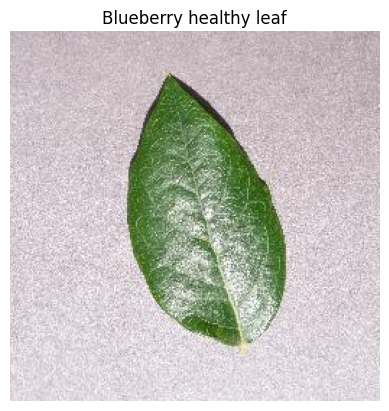

In [9]:
image_pth = "/content/plantvillage dataset/color/Blueberry___healthy/008c85d0-a954-4127-bd26-861dc8a1e6ff___RS_HL 2431.JPG"
img = mpimg.imread(image_pth)
plt.imshow(img)
plt.title("Blueberry healthy leaf")
plt.axis("off")
plt.show()

In [10]:
img_size = 128
batch_size = 32

Train-Test Split

In [11]:
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use 20% of data for validation
)

In [12]:
train_gen = data_gen.flow_from_directory(
    "/content/plantvillage dataset/color",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

Found 43456 images belonging to 38 classes.


In [13]:
test_gen = data_gen.flow_from_directory(
    "/content/plantvillage dataset/color",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)

Found 10849 images belonging to 38 classes.


In [14]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(train_gen.num_classes, activation='softmax'))
train_gen.num_classes

38

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 256)               1

In [16]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
fitted_model = model.fit(
    train_gen,
    epochs=5,
    validation_data=test_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    validation_steps=test_gen.samples // batch_size
)

Epoch 1/5
1358/1358 [==============================] - 67s 46ms/step - loss: 0.9324 - accuracy: 0.7312 - val_loss: 0.4281 - val_accuracy: 0.8621
Epoch 2/5
1358/1358 [==============================] - 60s 44ms/step - loss: 0.2986 - accuracy: 0.9036 - val_loss: 0.3513 - val_accuracy: 0.8875
Epoch 3/5
1358/1358 [==============================] - 60s 44ms/step - loss: 0.1525 - accuracy: 0.9487 - val_loss: 0.3774 - val_accuracy: 0.8898
Epoch 4/5
1358/1358 [==============================] - 64s 47ms/step - loss: 0.0958 - accuracy: 0.9681 - val_loss: 0.4204 - val_accuracy: 0.8908
Epoch 5/5
1358/1358 [==============================] - 61s 45ms/step - loss: 0.0704 - accuracy: 0.9756 - val_loss: 0.4525 - val_accuracy: 0.8906


In [18]:
print("Evaluating model...")
val_loss, val_accuracy = model.evaluate(test_gen, steps=test_gen.samples // batch_size)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Evaluating model...
339/339 [==============================] - 16s 48ms/step - loss: 0.4525 - accuracy: 0.8906
Validation Accuracy: 89.06%


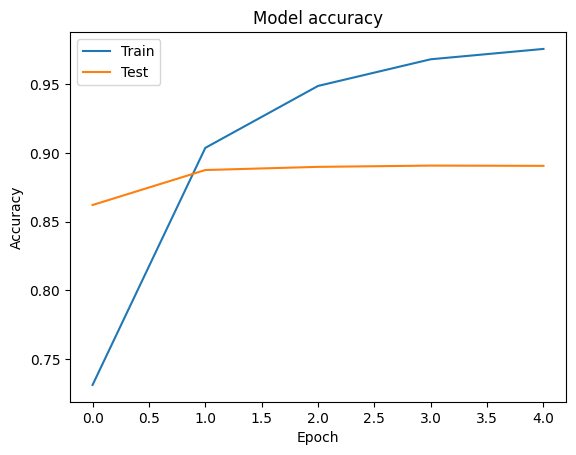

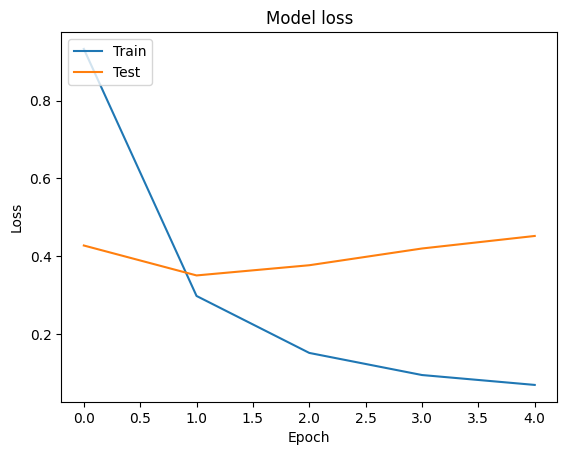

In [19]:
plt.plot(fitted_model.history['accuracy'])
plt.plot(fitted_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(fitted_model.history['loss'])
plt.plot(fitted_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [24]:
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    # Load the image
    img = Image.open(image_path)
    # Resize the image
    img = img.resize(target_size)
    # Convert the image to a numpy array
    img_array = np.array(img)
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    # Scale the image values to [0, 1]
    img_array = img_array.astype('float32') / 255.
    return img_array

# Function to Predict the Class of an Image
def predict_image_class(model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name

In [25]:
class_indices = {v: k for k, v in train_gen.class_indices.items()}

In [31]:

image_path = '/content/test_blueberry_healthy.jpg'
predicted_class_name = predict_image_class(model, image_path, class_indices)
prediction = predicted_class_name.replace("_"," ")
# Output the result
print("Predicted Class Name:", prediction)

1/1 [==============================] - 0s 24ms/step
Predicted Class Name: Blueberry   healthy
